# KPP teststand efficiency analysis 

## Imports

In [5]:
# External libraries
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt

In [6]:
# pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyimport as pyim
import pyprint as prnt
import pyplot as plot

pr = prnt.Print()
pl = plot.Plot()

In [7]:
# anapytools
from anapytools.read_data import DataReader
rd = DataReader()

## Read data

In [8]:
class ReadRec:
    """ Read rec tree as an awkward array"""
    def __init__(self):
        """ Initialise """
        self.treenames_ = ['run'] # List of tree names to read
    
    def read(self, filename):
        """ Read """
        # Open the file
        file = uproot.open(filename)
        
        # Get trees
        trees_ = {treename: file[treename] for treename in self.treenames_ if treename in file}
        
        # Combine arrays
        combined_array = []
        for treename, tree in trees_.items():
            # Extract branches into an Awkward Array
            array = tree.arrays(filter_name=["eventNumber", "PEsTemperatureCorrected", "time"], library="ak")
            combined_array.append(array)
        
        # Concatenate all arrays into a single Awkward Array
        combined_array = ak.concatenate(combined_array) if combined_array else ak.Array([])
        
        # Close file
        file.close()
        
        # Return combined Awkward Array
        return combined_array


In [9]:
# filename = '../Data/Reco/rec.mu2e.CRV_wideband_cosmics.crvaging-019.002100_000.root' # 1 hour 
def read_data(filename="../Data/Reco/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root"): # 5 hours of data or so
    reader = ReadRec()
    return reader.read(filename)
    
arrays = read_data()
arrays.type.show()

157287 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    time: 8 * 64 * float32
}


In [10]:
# for treename in reader.treenames_:
pr.PrintNEvents(arrays, 5)


---> Printing 5 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
eventNumber: 2
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 47.7, 50.2, 53.7, ..., 89.8, 131, 0, 0, 0, 0, 0, 0], ...]
time: [[nan, nan, nan, nan, nan, nan, 863, ..., nan, nan, nan, nan, nan, nan], ...]
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
eventNumber: 3
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 1.14, ..., 0, 0, 0, 1.04, 1.18, 0, 52.2, 57.6], ...]
time: [[nan, nan

## Stats

In [11]:
print("# Events:", len(arrays['PEsTemperatureCorrected'][:,0,0]))
print("# FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print("# Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

# Events: 157287
# FEBs: 8
# Channels / FEB: 64


## Basic PE histograms 

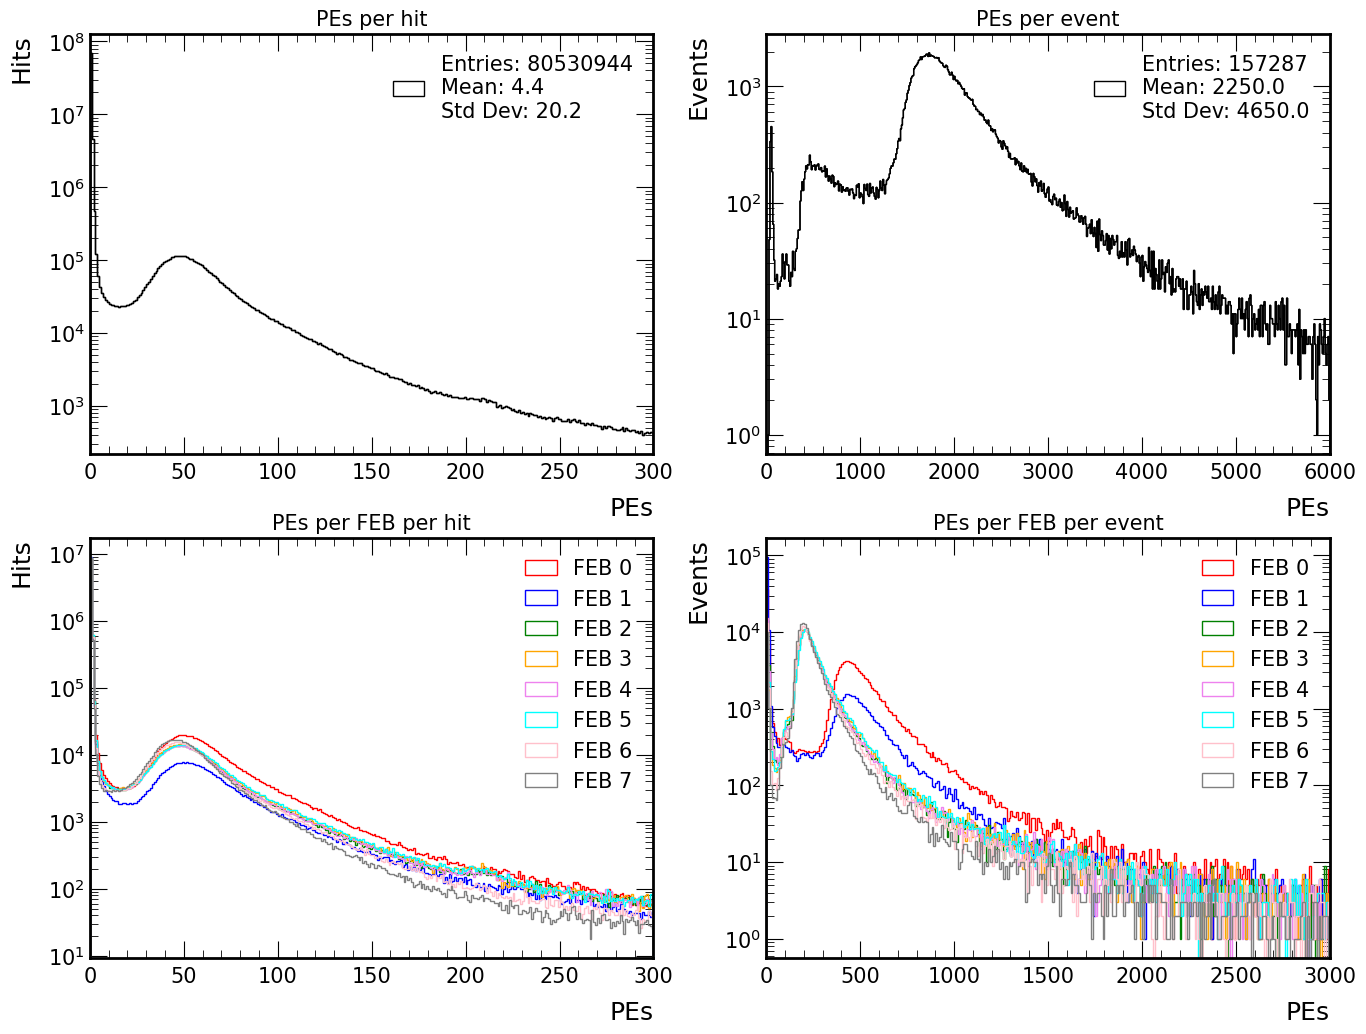

In [12]:
def PE_hists(arrays):
    # 4x4 plots
    fig, ax = plt.subplots(2, 2, figsize=(8*2, 6*2)) 
    
    pl.Plot1D(
        ak.flatten(arrays['PEsTemperatureCorrected'], axis=None),
        nbins=300, xmin=0, xmax=300,
        xlabel='PEs', ylabel='Hits', title='PEs per hit',
        log_y=True, ax=ax[0, 0] 
    )
    
    arrays['PEsPerEvent'] = ak.sum(arrays['PEsTemperatureCorrected'], axis=-1)
    arrays['PEsPerEvent'] = ak.sum(arrays['PEsPerEvent'], axis=-1) # deal with nesting
    
    pl.Plot1D(
        ak.flatten(arrays['PEsPerEvent'], axis=None), 
        nbins=600, xmin=0, xmax=6000,
        xlabel='PEs', ylabel='Events', title='PEs per event',
         log_y=True, ax=ax[0,1]
    )
    
    hists_ = {}
    for i_feb in range(8): 
        hists_[f'FEB {i_feb}'] = ak.flatten(arrays['PEsTemperatureCorrected'][:,i_feb,:], axis=None)
        
    pl.Plot1DOverlay(
        hists_,
        nbins=300, xmin=0, xmax=300,
        xlabel='PEs', ylabel='Hits', title='PEs per FEB per hit',
        log_y=True, ax=ax[1,0]
    )
    
    hists_ = {}
    for i_feb in range(8): 
        arrays[f'FEB{i_feb}PEsPerEvent'] = ak.sum(arrays['PEsTemperatureCorrected'][:,i_feb,:], axis=-1)
        hists_[f'FEB {i_feb}'] = ak.flatten(arrays[f'FEB{i_feb}PEsPerEvent'], axis=None)
        
    pl.Plot1DOverlay(
        hists_,
        nbins=300, xmin=0, xmax=3000,
        xlabel='PEs', ylabel='Events', title='PEs per FEB per event',
        log_y=True, ax=ax[1,1]
    )

PE_hists(arrays)

## Channel mapping (get PEs/layer)

In [28]:
class CrvAging019: 
    """ Build PEs / layer for each module as 4x32 arrays per event """
    def __init__(self, arrays, sanity=True):
        """ Initialise """
        print("---> Loading CrvAging019...")
        self.arrays = arrays
        self.sanity = sanity # sanity checks
        self.n_layers = 4
        self.n_channels_per_layer = 32

    def check_layers(self, layers, reshape):
        """ Helper function to check reshaped data """ 
        # Compare with nested array layers
        for i_layer in range(self.n_layers):
            layer_match = np.array_equal(
                ak.to_numpy(layers[i_layer]),
                ak.to_numpy(reshape[:, i_layer, :])
            )
            if not layer_match:
                print(f"Layer {i_layer} mismatch!")
                print(f"Original layer {i_layer}:", ak.to_numpy(layers[i_layer])[0])
                print(f"Reshaped layer {i_layer}:", ak.to_numpy(T_reshape[:, i_layer ,:])[0])
            else:
                print(f"Layer {i_layer} matches ✓")
        
    def crv_L_end(self):
        """
        Map the L-end channels
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
        FEBs 6-7 are split into two layers (channels 0-31 and 32-63).
        Final shape: (events, 4 layers, 32 channels)
    
        Layer mapping:
        - Layer 0: FEB6, channels 0-31
        - Layer 1: FEB6, channels 32-63
        - Layer 2: FEB7, channels 0-31
        - Layer 3: FEB7, channels 32-63
        """
        
        # Configuration for L-end module
        feb_indices = [6, 7]  # FEB indices 
        
        # Reshape
        l_end_reshape = ak.to_numpy(
            self.arrays['PEsTemperatureCorrected'][:, min(feb_indices):(max(feb_indices)+1), :] #  [:, 6:8, 0:64] layers 0-3
        ).reshape(-1, self.n_layers, self.n_channels_per_layer) # -1, 4, 64
        
        # Store 
        self.arrays['PEs_per_layer_L_end'] = l_end_reshape
    
        # Check against layers mapped by hand 
        if self.sanity:

            layers = [
                self.arrays['PEsTemperatureCorrected'][:,6,0:32], 
                self.arrays['PEsTemperatureCorrected'][:,6,32:64],
                self.arrays['PEsTemperatureCorrected'][:,7,0:32], 
                self.arrays['PEsTemperatureCorrected'][:,7,32:64] 
            ]
            
            self.check_layers(layers, l_end_reshape)

        return self.arrays

    def crv_T(self, single_ended=True):
        """
        Map the T channels, handling both single and double-ended readout.
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
    
        For double-ended: sum of FEBs 2&4 and 3&5
        For single-ended: only FEBs 2&3
        
        Final shape: (events, 4 layers, 32 channels)
        
        Layer mapping:
        - Layer 0: FEB 2&4, channels 0-31
        - Layer 1: FEB 2&4, channels 32-63
        - Layer 2: FEB 3&5, channels 0-31
        - Layer 3: FEB 3&5, channels 32-63
        """
        print("\n---> Mapping CRV-T")
        
        # Initiliase numpy container for reshaped data
        T_reshape = [] 
        
        if single_ended:
        
            # Single-ended readout 
            feb_indices = [2, 3]  
            
            # Reshape
            T_reshape = ak.to_numpy(
                self.arrays['PEsTemperatureCorrected'][:, min(feb_indices):(max(feb_indices)+1), :] # [:, 2:6, 0:64]
            ).reshape(-1, self.n_layers, self.n_channels_per_layer)
        
        else: 
    
            # Double-ended readout
            feb_indices = [ (2,3), (4,5) ] 
    
            # Layers 0 & 1 
            T_01 = ak.to_numpy( 
                (self.arrays['PEsTemperatureCorrected'][:, feb_indices[0][0], :] + self.arrays['PEsTemperatureCorrected'][:, feb_indices[1][0], :]) # [:, 2, :] + [:, 4, :] layer 0 & 1
            ).reshape(-1, n_layers/2, n_channels_per_layer) # Shape: events:2:32
    
            # Layers 2 & 3 
            T_23 = ak.to_numpy( 
                (self.arrays['PEsTemperatureCorrected'][:, feb_indices[0][1], :] + self.arrays['PEsTemperatureCorrected'][:, feb_indices[1][1], :]) # [:, 3, :] + [:, 5, :] layer 2 & 3
            ).reshape(-1, n_layers/2, n_channels_per_layer) # Shape: events:2:32
    
            # Stack them along axis 1 to get final shape (events, 4, 32)
            T_reshape = np.concatenate([T_01, T_23], axis=1)

        # Store
        self.arrays['PEs_per_layer_T'] = T_reshape
 
        # Check against layers mapped by hand 
        if self.sanity:

            layers = [] 
            
            if single_ended:
                layers.append(self.arrays['PEsTemperatureCorrected'][:,2,0:32]) 
                layers.append(self.arrays['PEsTemperatureCorrected'][:,2,32:64])
                layers.append(self.arrays['PEsTemperatureCorrected'][:,3,0:32])
                layers.append(self.arrays['PEsTemperatureCorrected'][:,3,32:64]) 
            else: 
                layers.append((self.arrays['PEsTemperatureCorrected'][:,2,0:32] + self.arrays['PEsTemperatureCorrected'][:,4,0:32]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,2,32:64] + self.arrays['PEsTemperatureCorrected'][:,4,32:64]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,3,0:32] + self.arrays['PEsTemperatureCorrected'][:,5,0:32]))
                layers.append((self.arrays['PEsTemperatureCorrected'][:,3,32:64] + self.arrays['PEsTemperatureCorrected'][:,5,32:64]))

            self.check_layers(layers, T_reshape)

        return self.arrays

    def crv_DS(self):
        """
        Map the DS channels, this one is weird
        Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
        
        Final shape: (events, 4 layers, 32 channels)
        
        Layer mapping:
        - Layer 0: FEB 0&1, channels 0-15
        - Layer 1: FEB 0&1, channels 16-31
        - Layer 2: FEB 0&1, channels 32-48
        - Layer 3: FEB 0&1, channels 49-64
        """
        print("\n---> Mapping CRV-DS")
        
        # Reshape
        DS_reshape = ak.to_numpy( 
            ak.concatenate([
                self.arrays['PEsTemperatureCorrected'][:,1,0:16], self.arrays['PEsTemperatureCorrected'][:,0,15::-1], # Layer 0 
                self.arrays['PEsTemperatureCorrected'][:,1,16:32], self.arrays['PEsTemperatureCorrected'][:,0,31:15:-1], # Layer 1
                self.arrays['PEsTemperatureCorrected'][:,1,32:48], self.arrays['PEsTemperatureCorrected'][:,0,47:31:-1], # Layer 2
                self.arrays['PEsTemperatureCorrected'][:,1,48:64], self.arrays['PEsTemperatureCorrected'][:,0,63:47:-1] # # Layer 3
            ], axis=-1)
        ).reshape(-1, self.n_layers, self.n_channels_per_layer)

        # Store
        self.arrays['PEs_per_layer_DS'] = DS_reshape
    
        # Check against layers mapped by hand 
        if self.sanity:
            
            layers = [
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,0:16], self.arrays['PEsTemperatureCorrected'][:,0,15::-1]], axis=-1), 
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,16:32], self.arrays['PEsTemperatureCorrected'][:,0,31:15:-1]], axis=-1),
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,32:48], self.arrays['PEsTemperatureCorrected'][:,0,47:31:-1]], axis=-1),
                ak.concatenate([self.arrays['PEsTemperatureCorrected'][:,1,48:64], self.arrays['PEsTemperatureCorrected'][:,0,63:47:-1]], axis=-1)
            ]
            self.check_layers(layers, DS_reshape)

        return self.arrays

In [29]:
# Run the mapping
# arrays = read_data()
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T()
arrays = crvaging019.crv_DS()

arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓
157287 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    time: 8 * 64 * float32,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
PEs_per_layer_L_end: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.07, ..., 0, 0, 0.886, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0

In [236]:
def crvaging019_DS(arrays, sanity=False):
    """
    Map the DS channels, this one is weird
    Produce PEs / layer array like [ [ [], [], [], [], ], [ [], [], [], [], ] ... ] events:layer:channel  
    
    Final shape: (events, 4 layers, 32 channels)
    
    Layer mapping:
    - Layer 0: FEB 0&1, channels 0-15
    - Layer 1: FEB 0&1, channels 16-31
    - Layer 2: FEB 0&1, channels 32-48
    - Layer 3: FEB 0&1, channels 49-64
    """

    # Configure DS module
    n_layers = 4
    n_channels_per_layer = 32 # FEB channels per layer
    # feb_indices = [0, 1] 

    # Reshape
    DS_reshape = ak.to_numpy( 
        ak.concatenate([
            arrays['PEsTemperatureCorrected'][:,1,0:16], arrays['PEsTemperatureCorrected'][:,0,15::-1], # Layer 0 
            arrays['PEsTemperatureCorrected'][:,1,16:32], arrays['PEsTemperatureCorrected'][:,0,31:15:-1], # Layer 1
            arrays['PEsTemperatureCorrected'][:,1,32:48], arrays['PEsTemperatureCorrected'][:,0,47:31:-1], # Layer 2
            arrays['PEsTemperatureCorrected'][:,1,48:64], arrays['PEsTemperatureCorrected'][:,0,63:47:-1] # # Layer 3
        ], axis=-1)
    ).reshape(-1, n_layers, n_channels_per_layer)

    # Store
    arrays['PEs_per_layer_DS'] = DS_reshape

    # Sanity check
    if sanity:
        arrays['PEs_DS_0'] = ak.concatenate([arrays['PEsTemperatureCorrected'][:,1,0:16], arrays['PEsTemperatureCorrected'][:,0,15::-1]], axis=-1) 
        arrays['PEs_DS_1'] = ak.concatenate([arrays['PEsTemperatureCorrected'][:,1,16:32], arrays['PEsTemperatureCorrected'][:,0,31:15:-1]], axis=-1) 
        arrays['PEs_DS_2'] = ak.concatenate([arrays['PEsTemperatureCorrected'][:,1,32:48], arrays['PEsTemperatureCorrected'][:,0,47:31:-1]], axis=-1)
        arrays['PEs_DS_3'] = ak.concatenate([arrays['PEsTemperatureCorrected'][:,1,48:64], arrays['PEsTemperatureCorrected'][:,0,63:47:-1]], axis=-1)

arrays = read_data()
arrays.type.show()
crvaging019_DS(arrays, True)
pr.PrintNEvents(arrays, 1)
# print(arrays['PEs_L_end_0'])
print(list(arrays['PEs_per_layer_DS'][0]))
arrays.type.show()

157287 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    time: 8 * 64 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0.916, 0, 0, 0, 0, 0, 1.12, 0, ..., 0, 1.13, 48.2, 64.3, 0, 0, 0, 0], ...]
time: [[1.12e+03, nan, nan, nan, nan, nan, ..., 863, 859, nan, nan, nan, nan], ...]
PEs_per_layer_DS: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 162, 0, 1.12, 0, 0, 0, 0, 0, 0.916], ...]
PEs_DS_0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 178, 162, 0, 1.12, 0, 0, 0, 0, 0, 0.916]
PEs_DS_1: [0, 0, 0, 0, 0, 0, 1.08, 0, 0, 0, 0, ..., 95.3, 84.3, 0, 0, 1.12, 0, 0, 0, 0, 0]
PEs_DS_2: [0, 0.897, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 1.11, 0, 0.921, 0, 0, 0, 0, 0, 0]
PEs_DS_3: [1.19, 0, 0, 0, 0, 0, 0, 1.05, 0, 0, ..., 1.13, 0, 0, 0, 0, 0, 0, 0.962, 0, 0]
-------------------------------------------------------------------------------------

[<Array [0, 0, 0, 0, 0, 0, 0